# Main
This script demonstrates how the whole pipeline should work.

In [1]:
# Imports
import sys
sys.path.append('../..')

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from help_project.src.disease_model import data
from help_project.src.disease_model.models import sir
from help_project.src.disease_model.utils import data_fetcher
from help_project.src.exitstrategies import data_elt
from help_project.src.exitstrategies import lockdown_policy
from help_project.src.economic_model.models import basic_lockdown_model as economy
from help_project.src.optimization import lockdown_config
from help_project.src.optimization import loss_function
from help_project.src.optimization import optimizer
from help_project.src.optimization import visualization

In [2]:
# Select one country
country = 'India'

start = datetime.date(2020, 5, 11)
end = datetime.date(2020, 6, 10)

print('Working on %s between %s and %s' % (country, start, end))

Working on India between 2020-05-11 and 2020-06-10


In [3]:
fetcher = data_fetcher.DataFetcher()
population_data = fetcher.get_population_data(country)
health_data = fetcher.get_health_data(country)

past_health_data = health_data[:start - datetime.timedelta(1)]
future_health_data = health_data[start:]

In [4]:
# Get all distinct policies used by any country at any point
policy_timeseries_by_country = data_elt.DataELT.extract_attribute_data()
all_policies = list(set(
    policy_application.policy
    for policy_timeseries in policy_timeseries_by_country.values()
    for policy_application in policy_timeseries[:start].policies
))

len(all_policies)

4

In [5]:
# Generate lockdown config - which chooses one of the precomputed policies
def generate_lockdown_policy(kwargs):
    policy = all_policies[kwargs['policy']]
    policy_ts = lockdown_policy.LockdownTimeSeries([
        lockdown_policy.LockdownPolicyApplication(
            policy=policy,
            start=start,
            end=end + datetime.timedelta(1))
    ])
    return policy_ts

lockdown_config.LockdownConfig.generate_lockdown_policy = generate_lockdown_policy
config = lockdown_config.LockdownConfig(
    policy=lockdown_config.Options([i for i, _ in enumerate(all_policies)]),
)

In [6]:
# Define health & econ model wrappers and the loss function
class HealthModelWrapper:
    def __init__(self, model, population_data, health_data):
        self.model = model
        self.population_data = population_data
        self.health_data = health_data

    def run(self, policy):
        return self.model.predict(self.population_data,
                                  self.health_data,
                                  policy)

In [7]:
# Create and fit a health model
health_model = sir.SIR()
health_model.fit(population_data, past_health_data, policy_timeseries_by_country['1_ind'][:start])
wrapped_health_model = HealthModelWrapper(
    health_model, population_data, past_health_data)

In [8]:
# Create the economic model
economic_model = economy.EconomicLockdownModel()

In [9]:
# Optimize and obtain the best result
opt = optimizer.ExhaustiveSearch(config, loss_function.ParetoLoss())
results = opt.optimize(population_data, wrapped_health_model, economic_model)

def describe_policy(policy):
    for country_key, policy_timeseries in policy_timeseries_by_country.items():
        for pol in policy_timeseries.policies:
            if pol.policy == policy:
                return 'Policy "%s" applied from %s to %s' % (country_key, pol.start, pol.end or 'now')
    return 'Not found'

for result in results:
    print('Deaths: %i, GDP: %.2f - %s' % (result.loss[0], -result.loss[1], describe_policy(result.solution.policies[0].policy)))

Deaths: 208748, GDP: 104147.86 - Policy "1_ind" applied from 2020-05-04 to 2020-05-18


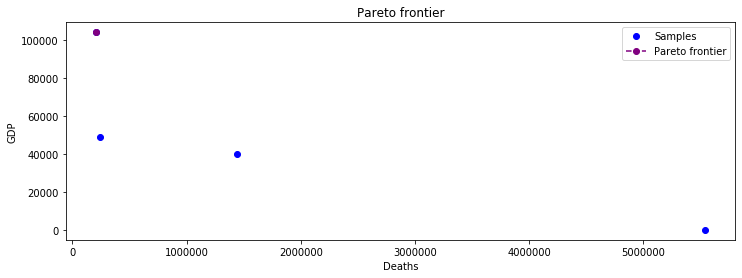

In [10]:
ax = visualization.Visualization.plot('Pareto frontier', 'Deaths', 'GDP')
visualization.Visualization.plot_samples(opt.results)
visualization.Visualization.pareto(results)
_ = plt.legend(['Samples', 'Pareto frontier'])

Wellby optimum:
--------------------
Policy "1_ind" applied from 2020-05-04 to 2020-05-18
208748 Deaths, GDP: 104147


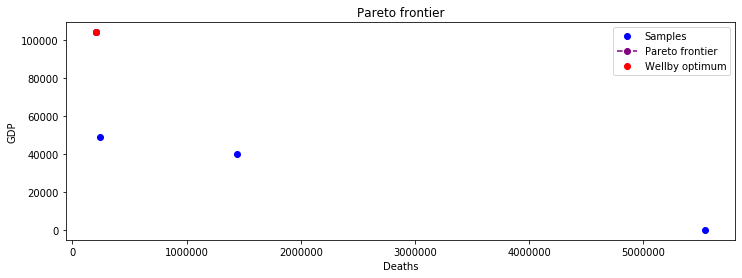

In [11]:
wellby = loss_function.WellbeingYears()
wellby_values = np.zeros(len(results))

# Re-run models to retrieve wellby values instead
for i, result in enumerate(results):
    health_output = wrapped_health_model.run(result.solution)
    economic_output = economic_model.get_economic_vector(result.solution)
    wellby_values[i] = -wellby.compute(population_data, health_output, economic_output)

argmax = np.argmax(wellby_values)
wellby_best = results[argmax]

print('Wellby optimum:')
print('--------------------')
print(describe_policy(wellby_best.solution.policies[0].policy))
print('%i Deaths, GDP: %i' % (int(wellby_best.loss[0]), -int(wellby_best.loss[1])))

ax = visualization.Visualization.plot('Pareto frontier', 'Deaths', 'GDP')
visualization.Visualization.plot_samples(opt.results)
visualization.Visualization.pareto(results)
visualization.Visualization.plot_samples([results[argmax]], color='red')
_ = plt.legend(['Samples', 'Pareto frontier', 'Wellby optimum'])

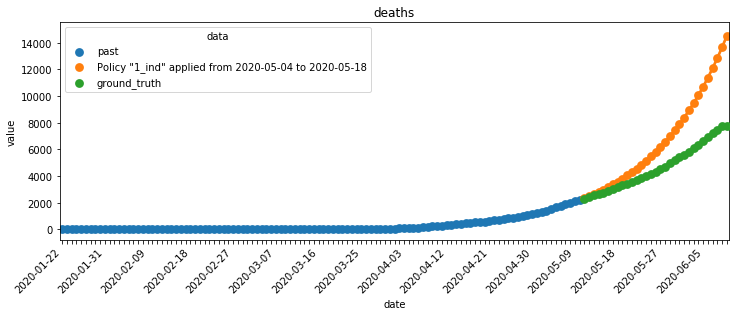

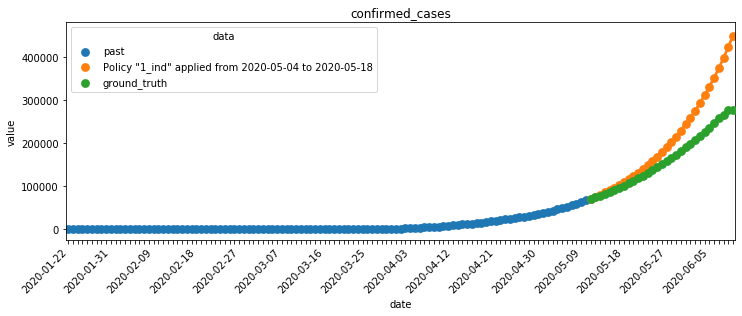

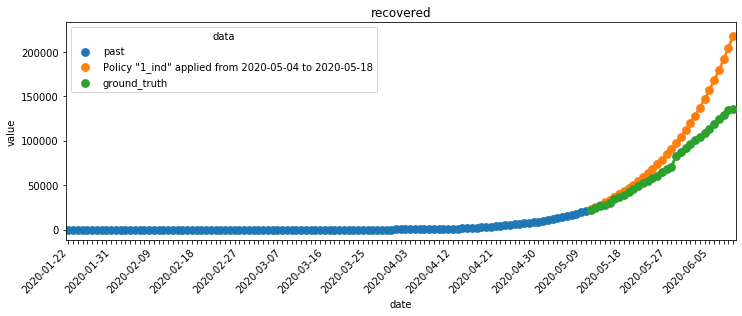

In [12]:
# Re-run pareto health models to retrieve predictions
predictions = {
    describe_policy(result.solution.policies[0].policy): wrapped_health_model.run(result.solution)
    for result in results
}

visualization.Visualization.plot_health_timeseries(
    ['deaths', 'confirmed_cases', 'recovered'],
    past_data=past_health_data,
    predictions=predictions,
    ground_truth=future_health_data,
)